In [58]:
import os

import pandas as pd
pd.set_option('display.max_columns', None)

import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

In [59]:
df = pd.read_csv(r'C:\Users\Garrett Pinkston\Desktop\TIM147\Project\data\RestaurantInfoComplete.csv')

In [60]:
df['zip'] = pd.to_numeric(df['postal_code'],errors='coerce')
df.dropna(inplace=True)

In [61]:
def sum_list(lst):
    return sum(eval(lst))

# Apply the function to the 'column_of_lists'
df['num_useful'] = (df['useful'].apply(sum_list))
df['num_funny'] = (df['funny'].apply(sum_list))
df['num_cool'] = (df['cool'].apply(sum_list))


In [62]:
# Add price range
df['Price'] = df['attributes'].apply(lambda x: eval(x).get('RestaurantsPriceRange2') if 'RestaurantsPriceRange2' in eval(x) else np.nan)
df['RestaurantsTakeOut'] = df['attributes'].apply(lambda x: eval(x).get('RestaurantsTakeOut') if 'RestaurantsTakeOut' in eval(x) else np.nan)

In [63]:
revisedDf = df[['stars','review_count','is_open','StarSlope','population','median_income','locations','chain','num_useful','num_funny','num_cool','Price','RestaurantsTakeOut']]

In [64]:
revisedDf = pd.get_dummies(revisedDf, columns=['chain'], prefix='chain')

In [65]:
df_with_none = revisedDf[revisedDf.applymap(lambda x: x == 'None').any(axis=1)]
revisedDf.replace('None', np.nan, inplace=True)
print("There are {} restaurants before dropping columns with null values".format(len(revisedDf)))
revisedDf.dropna(inplace=True)
print("There are {} restaurants after dropping columns with null values".format(len(revisedDf)))

revisedDf.replace('True', 1, inplace=True)
revisedDf.replace('False', 0, inplace=True)
revisedDf['Price'] = revisedDf['Price'].astype(int)


There are 18176 restaurants before dropping columns with null values
There are 15217 restaurants after dropping columns with null values


In [66]:
numRestaurantsClosed = (revisedDf['is_open']==1).sum()
numRestaurantsOpen = (revisedDf['is_open']==0).sum()
print("In the dataset, there are {} open restaurants, and {} closed restaurants".format(numRestaurantsOpen,numRestaurantsClosed))
print('A model that always prints "CLOSED" would achieve a baseline accuracy of {}%'.format(round((numRestaurantsClosed/(numRestaurantsClosed+numRestaurantsOpen))*100,2)))


In the dataset, there are 4737 open restaurants, and 10480 closed restaurants
A model that always prints "CLOSED" would achieve a baseline accuracy of 68.87%


In [10]:
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import accuracy_score

x = revisedDf.drop('is_open',axis=1)
y = revisedDf['is_open']
xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=0.2, random_state=42)

#subset data all Random CV search, then run model with optimized hyperparameters
X_subset, _, y_subset, _ = train_test_split(xtrain, ytrain, test_size=0.2, random_state=42)


In [11]:
from sklearn.ensemble import RandomForestClassifier

#grid of hyperparameters to randomly select
param_dist = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}


#instantiate rf, search for best params, fit model
rf = RandomForestClassifier()
random_search = RandomizedSearchCV(estimator=rf, param_distributions=param_dist, n_iter=10, cv=10, scoring='accuracy', n_jobs=-1)
random_search.fit(X_subset, y_subset)


#fit best params and make prediction over whole data
best_params_random = random_search.best_params_
best_rf_model_random = random_search.best_estimator_
predictionRF_random = best_rf_model_random.predict(xtest)

#rf accuracy using accuracy_score
accuracyRF_random = round(accuracy_score(ytest, predictionRF_random) * 100, 2)

print('Random Forest Classifier achieved max accuracy of {}% on test data with the RandomizedSearchCV optimized hyperparameters: {}'.format(accuracyRF_random, best_params_random))


Random Forest Classifier achieved max accuracy of 77.86% on test data with the RandomizedSearchCV optimized hyperparameters: {'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': None}


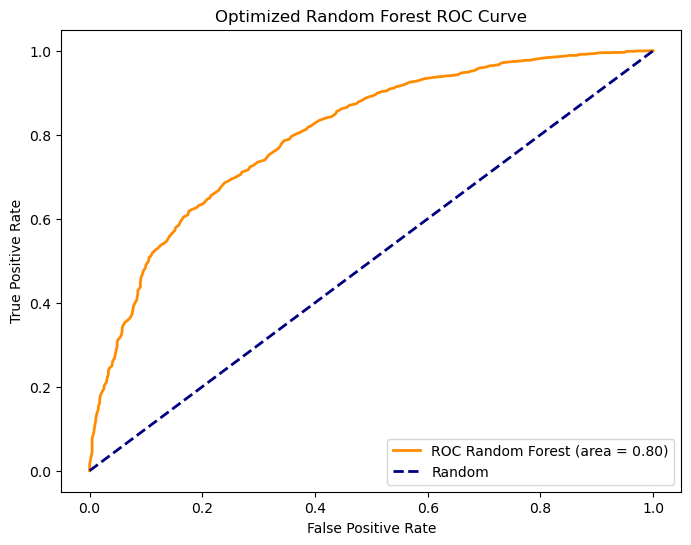

In [12]:
from sklearn.metrics import roc_curve, auc
y_prob = best_rf_model_random.predict_proba(xtest)[:, 1]

# apply roc and get false and true positive rates
fpr_rf, tpr_rf, _ = roc_curve(ytest, y_prob)
roc_auc_rf = auc(fpr_rf, tpr_rf)

#plot
plt.figure(figsize=(8, 6))
plt.plot(fpr_rf, tpr_rf, color='darkorange', lw=2, label='ROC Random Forest (area = {:.2f})'.format(roc_auc_rf))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Optimized Random Forest ROC Curve')
plt.legend(loc='lower right')
plt.savefig("RandomForest_ROC_plot.png")

In [44]:
#calculate optimal threshold, gives the probability of f1 score
from sklearn.metrics import precision_score, recall_score, f1_score

#prediction probability
y_probabilities = best_rf_model_random.predict_proba(xtest)[:, 1]

#threshold array and instantiate f1 score array
thresholds = np.arange(0.1,1,0.1)
f1_scores = []

# loop thru thresholds, score each model at threshold and append score to list 
for threshold in thresholds:
    y_pred = (y_probabilities > threshold).astype(int)
    precision = precision_score(ytest, y_pred)
    recall = recall_score(ytest, y_pred)
    f1 = f1_score(ytest, y_pred)
    f1_scores.append(f1)

# get index of maximum f1 score, keep the threshold
optimal_threshold = thresholds[np.argmax(f1_scores)]
final_predictions = (y_probabilities > optimal_threshold).astype(int)

Confusion Matrix:
[[ 421  478]
 [ 196 1949]]


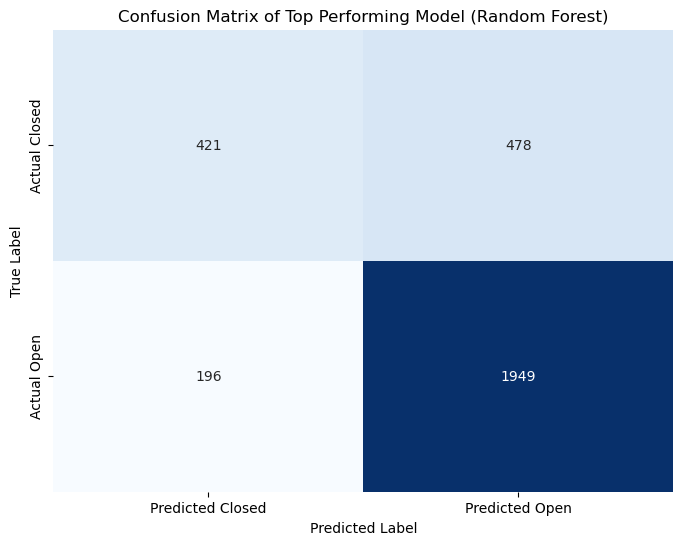

In [46]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

#optimal threshold found above
threshold = optimal_threshold 
y_pred_binary = (y_prob > threshold).astype(int)
conf_matrix = confusion_matrix(ytest, y_pred_binary)

#heatmap of confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted Closed', 'Predicted Open'],
            yticklabels=['Actual Closed', 'Actual Open'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix of Top Performing Model (Random Forest)')
plt.savefig("Confusion_Matrix_RandomForest.png")

In [13]:
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder


#already have subsets of data

#grid of hyperparameters to randomly select
param_dist = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2, 0.3],
    'max_depth': [3, 4, 5, 6, 7],
    'min_child_weight': [1, 2, 3, 4],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
    'gamma': [0, 0.1, 0.2, 0.3, 0.4],
    'reg_alpha': [0, 0.1, 0.2, 0.3, 0.4],
    'reg_lambda': [0, 0.1, 0.2, 0.3, 0.4]
}

#instantiate xg, search for best params, fit model
xg_classifier = xgb.XGBClassifier()
random_search = RandomizedSearchCV(estimator=xg_classifier, param_distributions=param_dist, n_iter=10, cv=10, scoring='accuracy', n_jobs=-1, random_state=42)
random_search.fit(X_subset, y_subset)

#fit best params and make prediction over whole data
best_params_random = random_search.best_params_
best_xg_model_random = random_search.best_estimator_
predictions_xg_random = best_xg_model_random.predict(xtest)

# Calculate accuracy
accuracy_xg_random = round(accuracy_score(ytest, predictions_xg_random) * 100, 2)

print('XGBoost achieved max accuracy of {}% on test data with the RandomizedSearchCV optimized hyperparameters: {}'.format(accuracy_xg_random, best_params_random))


XGBoost achieved max accuracy of 75.85% on test data with the RandomizedSearchCV optimized hyperparameters: {'subsample': 0.9, 'reg_lambda': 0.2, 'reg_alpha': 0, 'n_estimators': 200, 'min_child_weight': 3, 'max_depth': 4, 'learning_rate': 0.1, 'gamma': 0.2, 'colsample_bytree': 0.9}


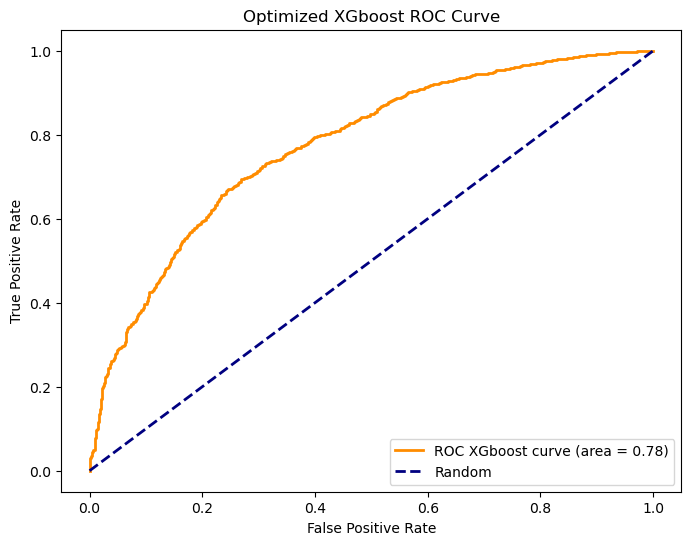

In [14]:
y_prob_xg = best_xg_model_random.predict_proba(xtest)[:, 1]

# Compute ROC curve and ROC area under curve
fpr_xg, tpr_xg, _ = roc_curve(ytest, y_prob_xg)
roc_auc_xg = auc(fpr_xg, tpr_xg)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_xg, tpr_xg, color='darkorange', lw=2, label='ROC XGboost curve (area = {:.2f})'.format(roc_auc_xg))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Optimized XGboost ROC Curve')
plt.legend(loc='lower right')
plt.savefig("XGBoost_ROC_plot.png")

In [15]:
#SVM/SVC
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_subset_scaled = scaler.fit_transform(X_subset)
xtest_scaled = scaler.transform(xtest)


#grid of hyperparameters to randomly select
param_dist = {
    'C': [1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto', 0.1],
}


#instantiate svm, search for best params, fit model
svm_classifier = SVC()
random_search = RandomizedSearchCV(estimator=svm_classifier, param_distributions=param_dist, n_iter=5, cv=5, scoring='accuracy', n_jobs=-1, random_state=42)

# Fit the model to the subset data, make predictions over everything
random_search.fit(X_subset_scaled, y_subset)
best_params_random = random_search.best_params_
best_svm_model_random = random_search.best_estimator_

# Calculate accuracy
predictions_svm_random = best_svm_model_random.predict(xtest_scaled)
accuracy_svm_random = round(accuracy_score(ytest, predictions_svm_random) * 100, 2)
print('SVM achieved max accuracy of {}% on test data with the RandomizedSearchCV optimized hyperparameters: {}'.format(accuracy_svm_random, best_params_random))


SVM achieved max accuracy of 73.62% on test data with the RandomizedSearchCV optimized hyperparameters: {'kernel': 'rbf', 'gamma': 'auto', 'C': 10}


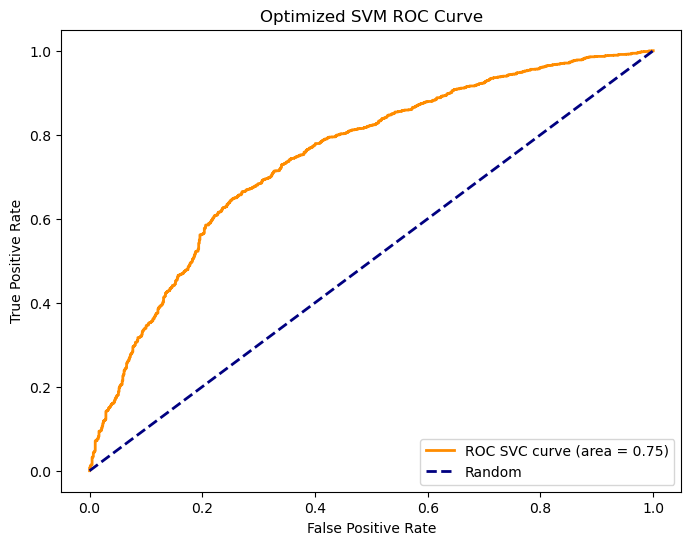

In [16]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

#scale features to speed up convergence, fit model to scaled features
X_train_scaled = scaler.fit_transform(xtrain)
X_test_scaled = scaler.transform(xtest)
best_svm_model_random.fit(X_train_scaled, ytrain)

# prediction probability
y_prob_svm = best_svm_model_random.decision_function(X_test_scaled)

# apply roc and get false and true positive rates
fpr_svm, tpr_svm, _ = roc_curve(ytest, y_prob_svm)
roc_auc_svm = auc(fpr_svm, tpr_svm)

# plot roc for svc
plt.figure(figsize=(8, 6))
plt.plot(fpr_svm, tpr_svm, color='darkorange', lw=2, label='ROC SVC curve (area = {:.2f})'.format(roc_auc_svm))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Optimized SVM ROC Curve')
plt.legend(loc='lower right')
plt.savefig("SVC_ROC_plot.png")

In [17]:
from sklearn.linear_model import LogisticRegression

# Scale your features
scaler = StandardScaler()
X_subset_scaled = scaler.fit_transform(X_subset)
xtest_scaled = scaler.transform(xtest)

# Define the parameter distribution for RandomizedSearchCV
param_dist = {
    'penalty': ['l2', 'none'],
    'C': [0.1, 1, 10, 100],
    'max_iter': [300, 500, 1000],
}

# Create the Logistic Regression Classifier
logreg_classifier = LogisticRegression()

# Create the RandomizedSearchCV object with fewer iterations
random_search = RandomizedSearchCV(estimator=logreg_classifier, param_distributions=param_dist, n_iter=5, cv=5, scoring='accuracy', n_jobs=-1, random_state=42)

# Fit the model to the subset data
random_search.fit(X_subset_scaled, y_subset)

# Get the best parameters and model
best_params_random = random_search.best_params_
best_logreg_model_random = random_search.best_estimator_

# Make predictions on the test set using the best model
predictions_logreg_random = best_logreg_model_random.predict(xtest_scaled)

# Calculate accuracy
accuracy_logreg_random = round(accuracy_score(ytest, predictions_logreg_random) * 100, 2)

print('Logistic Regression Classifier achieved max accuracy of {}% on test data with the best hyperparameters: {}'.format(accuracy_logreg_random, best_params_random))


Logistic Regression Classifier achieved max accuracy of 73.85% on test data with the best hyperparameters: {'penalty': 'l2', 'max_iter': 500, 'C': 1}


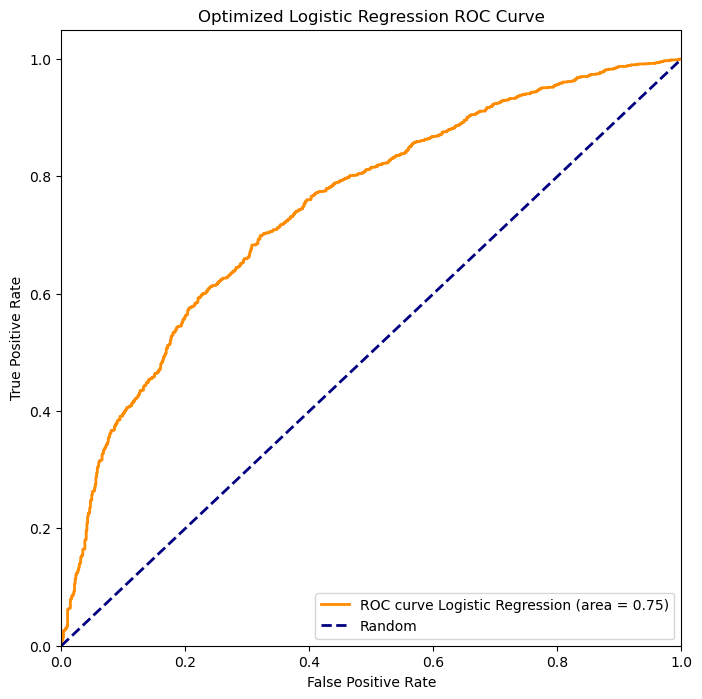

In [18]:
#plot ROC for LogRog

# prediction probability
probas_logreg_random = best_logreg_model_random.predict_proba(xtest_scaled)[:, 1]

# apply roc and get false and true positive rates, as well as area under curve
fpr_lr, tpr_lr, _ = roc_curve(ytest, probas_logreg_random)
roc_auc_lr = auc(fpr_lr, tpr_lr)

# Plot ROC
plt.figure(figsize=(8, 8))
plt.plot(fpr_lr, tpr_lr, color='darkorange', lw=2, label='ROC curve Logistic Regression (area = {:.2f})'.format(roc_auc_lr))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--',label='Random')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Optimized Logistic Regression ROC Curve')
plt.legend(loc='lower right')
plt.savefig("LogReg_ROC_plot.png")

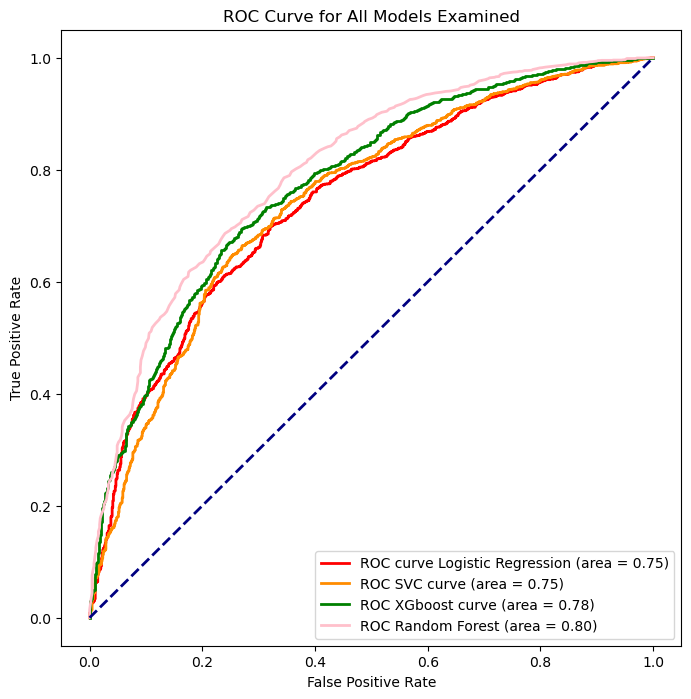

In [19]:
plt.figure(figsize=(8, 8))
plt.plot(fpr_lr, tpr_lr, color='red', lw=2, label='ROC curve Logistic Regression (area = {:.2f})'.format(roc_auc_lr))
plt.plot(fpr_svm, tpr_svm, color='darkorange', lw=2, label='ROC SVC curve (area = {:.2f})'.format(roc_auc_svm))
plt.plot(fpr_xg, tpr_xg, color='green', lw=2, label='ROC XGboost curve (area = {:.2f})'.format(roc_auc_xg))
plt.plot(fpr_rf, tpr_rf, color='pink', lw=2, label='ROC Random Forest (area = {:.2f})'.format(roc_auc_rf))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.legend()
plt.title("ROC Curve for All Models Examined")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.savefig("ROC_ALL")

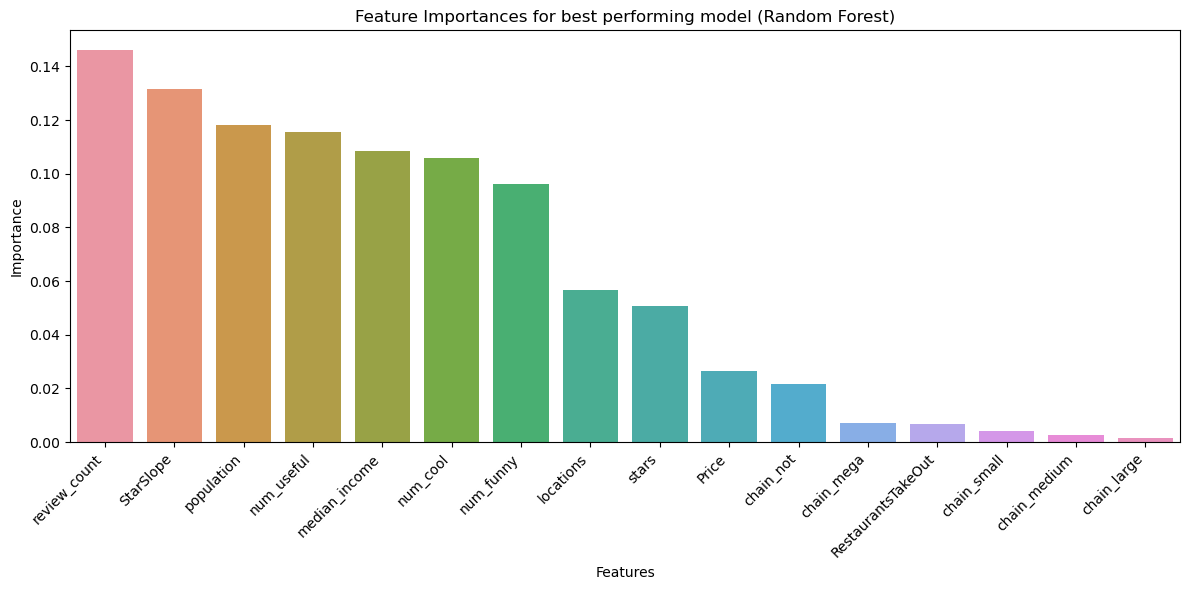

In [20]:
# feature importance of top model (Random Forest)

feature_importances = best_rf_model_random.feature_importances_
feature_names = X_subset.columns 
feature_importance_dict = dict(zip(feature_names, feature_importances))
sorted_feature_importance = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)

plt.figure(figsize=(12, 6))
sns.barplot(x=[x[0] for x in sorted_feature_importance], y=[x[1] for x in sorted_feature_importance])
plt.title('Feature Importances for best performing model (Random Forest)')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig("Feature_Importance_Best.png")